In [1]:
#!pip install keras_cv

import tensorflow as tf
import tensorflow_datasets as tfds
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import tqdm

%load_ext tensorboard

2022-12-30 12:41:17.920585: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-30 12:41:18.339769: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-30 12:41:18.375563: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-30 12:41:18.375582: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

### Prepare the Dataset

In [4]:
#1. get mnist from tensorflow datasets
mnist = tfds.load("mnist", split=["train","test"], as_supervised=True)
train_ds = mnist[0]
val_ds = mnist[1]

def cumsum_dataset(ds, seq_len):
  ds = ds.map(lambda x, t: tf.cast(t, dtype=tf.dtypes.int32))
  ds = ds.window(seq_len)
  def alternating_scan_function(state, elem):
    old_sign = state
    new_sign = old_sign*-1
    signed_target = elem*old_sign
    out_elem = signed_target
    new_state = new_sign
    return new_state, out_elem
  ds = ds.map(lambda sub_ds: sub_ds.scan(initial_state=1, scan_func=alternating_scan_function))
  def scan_cum_sum_function(state, elem):
    sum_including_this_elem = state+elem
    return sum_including_this_elem, sum_including_this_elem
  ds = ds.map(lambda sub_dataset: sub_dataset.scan(initial_state=0, scan_func=scan_cum_sum_function))
  ds = ds.map(lambda sub_dataset: sub_dataset.batch(seq_len).get_single_element())
  return ds


#2. Preproces the data using the map method or scan
def preprocess(data, batch_size, sequence_length):
  data = data.map(lambda x, t: (tf.cast(x, dtype=tf.float32)/255., t))
  ds = data.batch(sequence_length)
  targets = data.apply(lambda dataset: cumsum_dataset(dataset, sequence_length))
  ds = tf.data.Dataset.zip((ds, targets))
  ds = ds.map(lambda img, target: (img[0], target))
  ds = ds.shuffle(2000).batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)

  return ds

train_ds = preprocess(train_ds, batch_size=32, sequence_length=5)
val_ds = preprocess(val_ds, batch_size=32, sequence_length=5)

(32, 5)
(32, 5, 28, 28, 1)
tf.Tensor([ 0 -2  3 -4 -1], shape=(5,), dtype=int32)


2022-12-30 12:42:10.288844: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-12-30 12:42:10.298049: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


<Figure size 432x288 with 0 Axes>

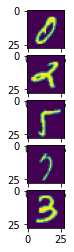

In [5]:
for img1, label in train_ds.take(1):
  print(label.shape)
  print(img1.shape)
  plt.figure()
  f, axarr = plt.subplots(5,1) 
  axarr[0].imshow(img1[0][0].numpy().squeeze())
  axarr[1].imshow(img1[0][1].numpy().squeeze())
  axarr[2].imshow(img1[0][2].numpy().squeeze())
  axarr[3].imshow(img1[0][3].numpy().squeeze())
  axarr[4].imshow(img1[0][4].numpy().squeeze())
  print(label[0])

### Optimise your model

In [6]:
class RNNCell(tf.keras.layers.AbstractRNNCell):

    def __init__(self, recurrent_units_1, recurrent_units_2, **kwargs):
        super().__init__(**kwargs)

        self.recurrent_units_1 = recurrent_units_1 # hidden state units
        self.recurrent_units_2 = recurrent_units_2 # cell state units
        
        self.linear_1 = tf.keras.layers.Dense(recurrent_units_1)
        self.linear_2 = tf.keras.layers.Dense(recurrent_units_2)
        
        # forget gate
        self.forget_gate = tf.keras.layers.Dense(recurrent_units_1, 
                                                       kernel_initializer= tf.keras.initializers.Orthogonal(
                                                           gain=1.0, seed=None),
                                                       activation='sigmoid')
        # layer normalization for trainability
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        
        # input gate
        self.input_gate = tf.keras.layers.Dense(recurrent_units_1, 
                                                       kernel_initializer= tf.keras.initializers.Orthogonal(
                                                           gain=1.0, seed=None), 
                                                       activation='sigmoid')
        # cell-state candidates
        self.cellstate_candidates = tf.keras.layers.Dense(recurrent_units_1, 
                                                       kernel_initializer= tf.keras.initializers.Orthogonal(
                                                           gain=1.0, seed=None), 
                                                       activation=tf.nn.tanh)
        # output gate                                               
        self.output_gate = tf.keras.layers.Dense(recurrent_units_1, 
                                                       kernel_initializer= tf.keras.initializers.Orthogonal(
                                                           gain=1.0, seed=None), 
                                                       activation='sigmoid')

        # layer normalization for trainability
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
    
    @property
    def state_size(self):
        return [tf.TensorShape([self.recurrent_units_1]), 
                tf.TensorShape([self.recurrent_units_2])]
    @property
    def output_size(self):
        return [tf.TensorShape([self.recurrent_units_2])]
    
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return [tf.zeros([self.recurrent_units_1]), 
                tf.zeros([self.recurrent_units_2])]

    def call(self, inputs, states):
        # unpack the states
        hidden_state = states[0]
        cell_state = states[1]
        
        # linearly project input
        x = self.linear_1(inputs) + hidden_state
        
        # apply forget gate
        forget_candidates = self.forget_gate(x)
        # apply layer norm
        #x = self.layer_norm_1(new_hidden_state)

        # apply input gate
        new_input = self.input_gate(x)
        new_candidates = self.cellstate_candidates(x)
        # apply layer norm
        #x = self.layer_norm_1(new_hidden_state)
        
        new_cell_state = forget_candidates * cell_state + new_input * new_candidates

        # output gate
        output= self.output_gate(x)
        new_hidden_state = output * tf.nn.tanh(new_cell_state)
        
        # return output and the list of new states of the layers
        return x, [new_hidden_state, new_cell_state]
    
    def get_config(self):
        return {"recurrent_units_1": self.recurrent_units_1, 
                "recurrent_units_2": self.recurrent_units_2}

In [7]:
class CNN_LSTMModel(tf.keras.Model):

  #1 Constructor
  def __init__(self, batch_size, sequence_len):
    super(CNN_LSTMModel, self).__init__()
    #optimizer, loss function and metrics
    self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    self.loss = tf.keras.losses.MeanAbsoluteError()
    self.metrics_list = [
                        tf.keras.metrics.MeanAbsoluteError(name="loss")
                        #tf.keras.metrics.Accuracy(name="acc")
                       ]

    input_shape = (batch_size, sequence_len, 28, 28, 1)

    self.rnn_cell = RNNCell(recurrent_units_1=24,
                                recurrent_units_2=24)
        

    self.layer_list = [
      tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape[2:]),
      tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization()),
      tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape[2:]),
      tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization()),
      tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)),
      tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=input_shape[2:]),
      tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization()),
      tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=input_shape[2:]),
      tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization()),
      tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalAvgPool2D()),
      tf.keras.layers.Dense(24, activation='softmax'),
      tf.keras.layers.RNN(self.rnn_cell, return_sequences=True, unroll=True),
      tf.keras.layers.Dense(1)
    ]

    #2. call method (forward computation)
  def call(self, x, training=False):
      for layer in self.layer_list[:-1]:
        x = layer(x)
      return self.layer_list[-1](x)

  #3. metrics property
  @property
  def metrics(self):
    # return a list with all metrics in the model
    return self.metrics_list


  #4 reset all metrics object
  def reset_metrics(self):
    for metric in self.metrics:
      metric.reset_states()

  def train_step(self, data):
    sequence, label = data
    with tf.GradientTape() as tape:
      output = self(sequence, training=True)
      #loss = self.compiled_loss(label, output, regularization_losses=self.losses)
      loss = self.loss(label, output)
    
    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    #update metrics
    self.metrics[0].update_state(label, output)
    #self.metrics[1].update_state(label, output)
    return {m.name : m.result() for m in self.metrics}

  def test_step(self, data, return_predictions=False):
    sequence, label = data
    output = self(sequence, training=False)
    if return_predictions:
      print(output[0])
    #loss = self.compiled_loss(label, output, regularization_losses=self.losses)
    loss = self.loss(label, output)
    self.metrics[0].update_state(label, output)
    #self.metrics[1].update_state(label, output)
    return {m.name : m.result()  for m in self.metrics}

In [8]:
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_path = f"logs/train/"
val_log_path = f"logs/val/"
train_summary_writer = tf.summary.create_file_writer(train_log_path + current_time)
val_summary_writer = tf.summary.create_file_writer(val_log_path + current_time)

In [9]:
EXPERIMENT_NAME = "RNN_noise"
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
logging_callback = tf.keras.callbacks.TensorBoard(log_dir=f"./logs/{EXPERIMENT_NAME}/{current_time}")

In [10]:
model = CNN_LSTMModel(batch_size=32, sequence_len=5)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = tf.keras.losses.MeanSquaredError()

# compile the model (here, adding a loss function and an optimizer)
model.compile(optimizer = optimizer, loss=loss)

In [11]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    initial_epoch=0,
                    epochs=50,
                    callbacks=[logging_callback])

Epoch 1/50


ValueError: in user code:

    File "/home/annalena/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/annalena/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/annalena/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/tmp/ipykernel_9480/2636875523.py", line 57, in train_step
        output = self(sequence, training=True)
    File "/home/annalena/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_file9tmvg206.py", line 23, in tf__call
        ag__.for_stmt(ag__.ld(self).layer_list[:-1], None, loop_body, get_state, set_state, ('x',), {'iterate_names': 'layer'})
    File "/tmp/__autograph_generated_file9tmvg206.py", line 21, in loop_body
        x = ag__.converted_call(ag__.ld(layer), (ag__.ld(x),), None, fscope)

    ValueError: Exception encountered when calling layer 'cnn_lstm_model' (type CNN_LSTMModel).
    
    in user code:
    
        File "/tmp/ipykernel_9480/2636875523.py", line 39, in call  *
            x = layer(x)
        File "/home/annalena/anaconda3/lib/python3.9/site-packages/keras/layers/rnn/base_rnn.py", line 556, in __call__  **
            return super().__call__(inputs, **kwargs)
        File "/home/annalena/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
            raise e.with_traceback(filtered_tb) from None
        File "/home/annalena/anaconda3/lib/python3.9/site-packages/keras/layers/rnn/base_rnn.py", line 664, in call
            raise ValueError(
    
        ValueError: Exception encountered when calling layer 'rnn' (type RNN).
        
        Cannot unroll a RNN if the time dimension is undefined. 
        - If using a Sequential model, specify the time dimension by passing an `input_shape` or `batch_input_shape` argument to your first layer. If your first layer is an Embedding, you can also use the `input_length` argument.
        - If using the functional API, specify the time dimension by passing a `shape` or `batch_shape` argument to your Input layer.
        
        Call arguments received by layer 'rnn' (type RNN):
          • inputs=tf.Tensor(shape=(None, None, 24), dtype=float32)
          • mask=None
          • training=True
          • initial_state=None
          • constants=None
    
    
    Call arguments received by layer 'cnn_lstm_model' (type CNN_LSTMModel):
      • x=tf.Tensor(shape=(None, None, 28, 28, 1), dtype=float32)
      • training=True


In [12]:
def visualisation(train_losses, train_acc, test_losses, test_acc):
  plt.figure ()
  line1, = plt.plot(train_losses , "b-" )
  line2, = plt.plot(test_losses , "r-" )
  #line3, = plt.plot(train_acc , "b:" )
  #line4, = plt.plot(test_acc , "r:" )
  plt.xlabel( " Training steps " )
  plt.ylabel( " Loss / Accuracy " )
  plt.legend((line1, line2), ("training loss", "test loss"))
  plt.show()

In [13]:
def training_loop(model, train_ds, val_ds, epochs, train_summary_writer, val_summary_writer, save_path):
  train_loss = []
  val_loss = []
  train_acc = []
  val_acc = []

  #1. iterate over epochs
  for e in range(epochs):
    #2. train steps on all batchs in the training data
    for data in tqdm.tqdm(train_ds):
      metrics = model.train_step(data)
    # 3. log and print data metrics
    with train_summary_writer.as_default():
      for metric in model.metrics:
        print(metric)
        tf.summary.scalar(f"{metric.name}", metric.result(), step=e)
    
    for (key, value) in metrics.items():
      #if key == 'acc':
        #train_acc.append(value.numpy())
      if key == 'loss':
        train_loss.append(value.numpy())

    # print the metrics
    print([f"{key}: {value.numpy()}" for (key, value) in metrics.items()])

    #4 reset the metrics
    model.reset_metrics()

    #5. evaluate on validation data
    for data in val_ds:
      metrics = model.test_step(data)
    
    #6. log validation metrics
    with val_summary_writer.as_default():
      for metric in model.metrics:
        print(metric)
        tf.summary.scalar(f"{metric.name}", metric.result(), step=e)
    
    for (key, value) in metrics.items():
      #if key == 'acc':
        #val_acc.append(value.numpy())
      if key == 'loss':
        val_loss.append(value.numpy())


    # print the metrics
    print([f"{key}: {value.numpy()}" for (key, value) in metrics.items()])
    
    #7. reset metric objects
    model.reset_metrics()

  model.save_weights(save_path)
  return train_loss, val_loss, train_acc, val_acc

**Training model without regularisation**

In [44]:
#train_ds = proccess(train_ds, batch_size=32)
#val_ds = proccess(val_ds, batch_size=32)


model = CNN_LSTMModel(batch_size=32, sequence_len=5)
#model(tf.keras.Input((32,32,3)))
#model.summary()
epochs=20

#2. choose a path to save the weights
save_path = "trained_model"

train_loss, val_loss, train_acc, val_acc = training_loop(model, train_ds, val_ds, epochs, train_summary_writer, val_summary_writer, save_path)
#visualisation(train_loss, train_acc, val_loss, val_acc)


100%|██████████| 375/375 [01:32<00:00,  4.05it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 4.297207832336426']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 4.491774082183838']


100%|██████████| 375/375 [01:32<00:00,  4.04it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 3.111403226852417']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 3.0240721702575684']


100%|██████████| 375/375 [01:32<00:00,  4.04it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.5839955806732178']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.529127359390259']


100%|██████████| 375/375 [01:32<00:00,  4.05it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.4269275665283203']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.4477577209472656']


100%|██████████| 375/375 [01:32<00:00,  4.04it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.3534939289093018']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.3807575702667236']


100%|██████████| 375/375 [01:32<00:00,  4.07it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.3035330772399902']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.3796496391296387']


100%|██████████| 375/375 [01:32<00:00,  4.06it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.2671396732330322']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.3135149478912354']


100%|██████████| 375/375 [01:32<00:00,  4.04it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.2393076419830322']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.276466131210327']


100%|██████████| 375/375 [01:32<00:00,  4.04it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.2176921367645264']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.2722127437591553']


100%|██████████| 375/375 [01:32<00:00,  4.06it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.1974544525146484']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.2554330825805664']


100%|██████████| 375/375 [01:32<00:00,  4.05it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.1800153255462646']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.2374191284179688']


100%|██████████| 375/375 [01:32<00:00,  4.04it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.165698289871216']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.2751431465148926']


100%|██████████| 375/375 [01:33<00:00,  4.02it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.1540019512176514']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.280911445617676']


100%|██████████| 375/375 [01:33<00:00,  4.03it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.1429553031921387']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.2255055904388428']


100%|██████████| 375/375 [01:32<00:00,  4.05it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.129734754562378']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.2358779907226562']


100%|██████████| 375/375 [01:33<00:00,  4.02it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.1214346885681152']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.2452914714813232']


100%|██████████| 375/375 [01:32<00:00,  4.04it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.1138384342193604']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.2309625148773193']


100%|██████████| 375/375 [01:36<00:00,  3.88it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.1067516803741455']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.248706340789795']


100%|██████████| 375/375 [01:33<00:00,  4.02it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.1006014347076416']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.259290933609009']


100%|██████████| 375/375 [01:33<00:00,  4.03it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.094290018081665']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.244666337966919']


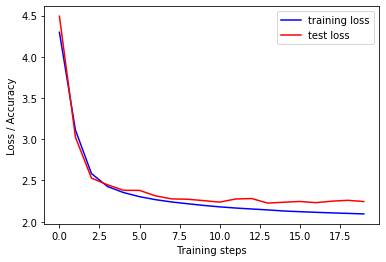

In [45]:
visualisation(train_loss, train_acc, val_loss, val_acc)

(32, 5)
(32, 5, 28, 28, 1)
tf.Tensor([ 2  2  6 -2  5], shape=(5,), dtype=int32)
tf.Tensor(
[[ 2.0564184]
 [-6.1020756]
 [ 6.2947497]
 [ 4.7774215]
 [ 4.691855 ]], shape=(5, 1), dtype=float32)


<Figure size 432x288 with 0 Axes>

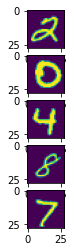

In [46]:
for img1, label in val_ds.take(1):
  print(label.shape)
  print(img1.shape)
  plt.figure()
  f, axarr = plt.subplots(5,1) 
  axarr[0].imshow(img1[0][0].numpy().squeeze())
  axarr[1].imshow(img1[0][1].numpy().squeeze())
  axarr[2].imshow(img1[0][2].numpy().squeeze())
  axarr[3].imshow(img1[0][3].numpy().squeeze())
  axarr[4].imshow(img1[0][4].numpy().squeeze())
  print(label[0])
  model.test_step((img1,label), return_predictions=True)